In [291]:
!pip install qiskit-algorithms
!pip install qiskit-machine-learning
!pip install qiskit-aer
!pip install nlpaug
!pip install googletrans==3.1.0a0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.2 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=a5b13d212243dea456851dc0a5a297cda7490b566714523c84aff58736dfa3f3
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: h11
    

In [294]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit import qasm2

import pickle

import nlpaug
import nlpaug.augmenter.word as naw
import nltk

from googletrans import Translator
# Set seed for random generators
algorithm_globals.random_seed = 42

In [295]:
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
lemmatize = nltk.WordNetLemmatizer()
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [320]:
df = pd.read_csv('/content/task-3-dataset.csv')
df

,отзывы,разметка
0,Оболочка после чистого андроида тоже очень нек...,-
1,"Нормальный телефон, очень красивая задняя панель",+
2,Деньги на ветер .,-
3,ну так себе,-
4,Ценник вполне адекватный для такой мощной нови...,+
...,...,...
205,"Короче, можно брать. Но есть моменты, которые ...",+
206,очень крутой дизайн,+
207,"Звук ужасный, собеседника очень плохо слышно, ...",-
208,10 раз подумайте прежде чем покупать. Весьма с...,-


In [321]:
# используя методы аугментации, увеличим размер датасета, создав новые отрицательные отзывы
aug = naw.SynonymAug(aug_src='wordnet',aug_max=4)
translator = Translator()
neg_reviews = df[df['разметка'] == '-']
neg_words = []
for t in neg_reviews['отзывы']:
    neg_words.append(t)
aug_neg_words = []
for word in neg_words:
    augmentation = aug.augment(translator.translate(word, dest='en').text, n=4)
    for phrase in augmentation:
        tranlation = translator.translate(phrase, dest='ru')
        aug_neg_words.append(tranlation.text)
        df = pd.concat([df, pd.DataFrame([{'отзывы' : tranlation.text, 'разметка' : '-'}])], ignore_index=True)
neg_text = pd.Series(aug_neg_words).str.cat(sep=' ')
aug_neg_words[:4]

['Оболочка после чистого гуманоида тоже очень неудобна, но это дело вкуса и привычки.',
 'Оболочка после чистого андроида слишком уж неудобна, просто это дело вкуса и привычки.',
 'Случай после чистого андроида тоже очень неудобен, но это дело вкуса и привычки.',
 'Яичная скорлупа после чистого андроида слишком уж неудобна, но это вопрос вкусового восприятия и привычки.']

In [322]:
# используя методы аугментации, увеличим размер датасета, создав новые положительные отзывы
pos_reviews = df[df['разметка'] == '+']
pos_words = []
for t in pos_reviews['отзывы']:
    pos_words.append(t)
aug_pos_words = []
for word in pos_words:
    augmentation = aug.augment(translator.translate(word, dest='en').text, n=4)
    for phrase in augmentation:
        tranlation = translator.translate(phrase, dest='ru')
        aug_pos_words.append(tranlation.text)
        df = pd.concat([df, pd.DataFrame([{'отзывы' : tranlation.text, 'разметка' : '+'}])], ignore_index=True)
pos_text = pd.Series(aug_pos_words).str.cat(sep=' ')
aug_pos_words[:4]

['Правило телефона, дребезжащая красивая задняя панель',
 'Нормальный наушник, очень красивая задняя панель.',
 'Обычный телефон, очень красивая задняя панель.',
 'Нормальный звук речи, очень красивая задняя панель']

In [345]:
# сохраним увеличенный датасет
df.to_csv('expanded_df_3rd_task.csv', index=False)

In [347]:
df = pd.read_csv('/content/expanded_df_3rd_task.csv')

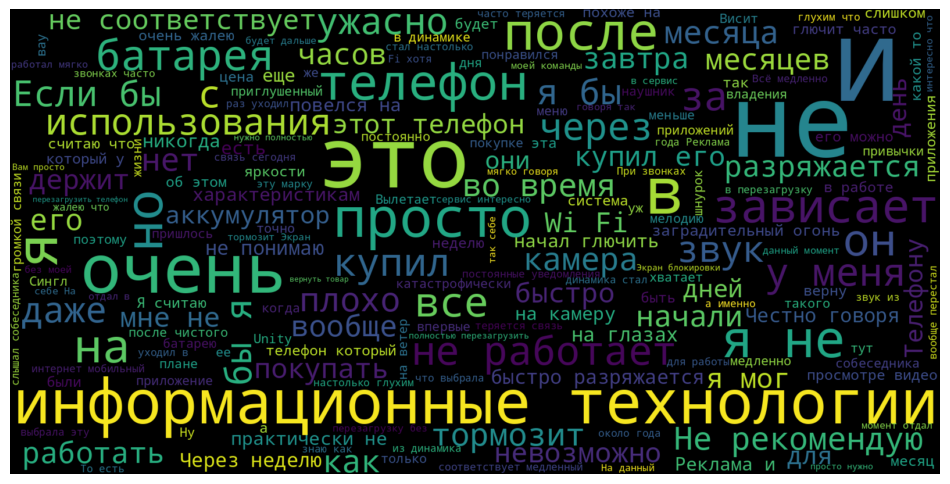

In [323]:
#визуализируем ключевые слова в отрицательных отзывах, чтобы составить словарь стоп-слов
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

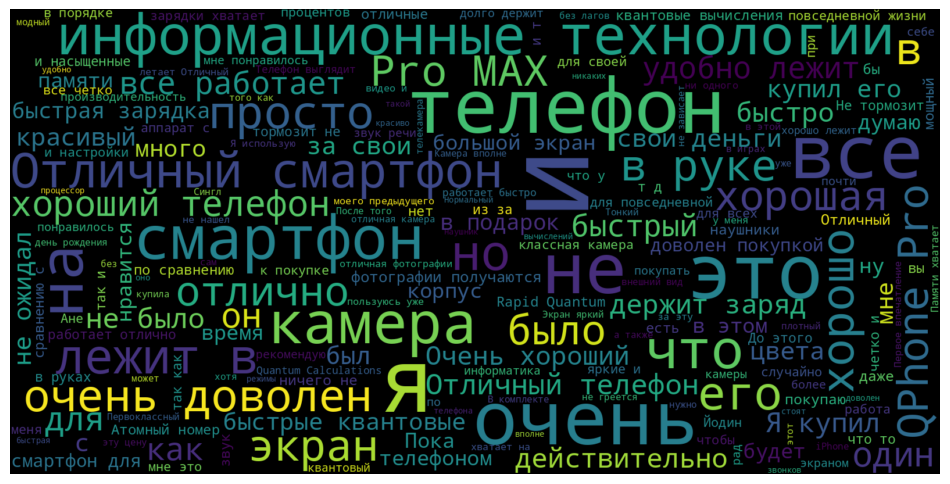

In [324]:
#визуализируем ключевые слова в положительных отзывах, чтобы составить словарь стоп-слов
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [325]:
#загружаем словарь со стоп-словами и чистим наш датасет
with open("/content/stopWords.txt") as file:
    data = [line.strip() for line in file]
stopwords = []
for word in data:
    word = word.replace(',', "")
    word = word.replace('\'', "")
    stopwords.append(word)

In [326]:
phrase = np.array(df['отзывы'])
df['разметка'] = df['разметка'].replace({'+': 1, '-': 0})
sentiments = np.array(df['разметка'])

<ipython-input-326-4782791b4be9>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['разметка'] = df['разметка'].replace({'+': 1, '-': 0})


In [327]:
def preprocess_text(phrase):
    phrase_clear = []
    for i in phrase:
        #удаляем неалфавитные символы
        text = re.sub("[^а-яёА-ЯЁ]"," ",i.lower())
        # токенизируем слова
        text = nltk.word_tokenize(text,language = "russian")
        # лемматирзируем слова
        lemm_text = []
        for word in text:
            # if word not in set(stopwords.words("russian")):
            #     lemm_text.append(lemmatize.lemmatize(word))
            if word not in set(stopwords):
                lemm_text.append(lemmatize.lemmatize(word))
        # соединяем слова
        lemm_text = " ".join(lemm_text)
        phrase_clear.append(lemm_text)
    return(phrase_clear)

In [328]:
#формируем тренировочный и тестовый датасеты
phrase_train, phrase_test, sentiments_train, sentiments_test = train_test_split(preprocess_text(phrase), sentiments, test_size=0.3, random_state=4)

In [329]:
## Строим модели векторизации "Мешок слов"
cv = CountVectorizer(stop_words=stopwords, max_features=10000)

tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)

In [330]:
cntVec = cv.fit(preprocess_text(phrase))
tfidfVec = tv.fit(preprocess_text(phrase))
#сохраним векторизаторы фраз для подключения в скрипте
with open('bOfW.pkl', 'wb') as fout:
    pickle.dump((cntVec, tfidfVec), fout)

cv_train_features = cv.transform(phrase_train)
tv_train_features = tv.transform(phrase_train)

cv_test_features = cv.transform(phrase_test)
tv_test_features = tv.transform(phrase_test)

In [331]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (735, 2599)  Test features shape: (315, 2599)
TFIDF model:> Train features shape: (735, 7793)  Test features shape: (315, 7793)


In [348]:
#Формируем тренировочную и тестовую выборки. Тесты показали,
#что эффективность векторизации tfidf выше, используем ее

X_train = tv_train_features.toarray()
y_train = sentiments_train
# переводим в тензоры pytorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train)

# создаем загрузчик тренировочных данных
train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=1)

X_test = tv_test_features.toarray()
y_test = sentiments_test
# переводим в тензоры pytorch
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test)

# создаем загрузчик тестовых данных
test_loader = DataLoader(list(zip(X_test, y_test)), shuffle=True, batch_size=1)

In [333]:
# Создаем квантовые слои нейросети, состоящие из ZZFeatureMap и вариационных слоев
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True
    )
    return qnn


qnn4 = create_qnn()

<ipython-input-333-99e72446ad15>:10: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
<ipython-input-333-99e72446ad15>:10: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (2). If `circuit` is transpiled, this may cause unstable behaviour.
  qnn = EstimatorQNN(


In [336]:
# создаем итоговую нейросеть, используем полносвязный перцептрон с квантовыми слоями
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.fc1 = Linear(X_train.shape[1], 64)
        self.fc2 = Linear(64, 2)
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 1)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

In [337]:
# Определяем модель, оптимизатор и функцию потерь
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

epochs = 10  # число эпох
loss_list = []  # история потерь
model4.train()  # переводим модель в режим обучения
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # инициализируем градиент
        output = model4(data)  # прямое распространение
        loss = loss_func(output, target)  # считаем потери
        loss.backward()  # обратное распространение
        optimizer.step()  # оптимизируем веса
        total_loss.append(loss.item())  # записываем текущие потери
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -0.7197
Training [20%]	Loss: -1.5334
Training [30%]	Loss: -2.3923
Training [40%]	Loss: -3.1960
Training [50%]	Loss: -3.9995
Training [60%]	Loss: -4.7689
Training [70%]	Loss: -5.5228
Training [80%]	Loss: -6.3010
Training [90%]	Loss: -7.0564
Training [100%]	Loss: -7.7630


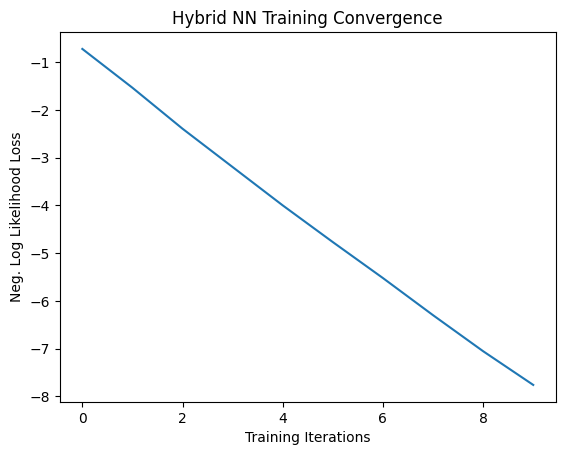

In [338]:
# построим функцию сходимости потерь
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [340]:
model4.eval()  # переводим модель в режим вычислений
batch_size=1
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model4(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: -7.2460
	Accuracy: 91.4%


In [341]:
#параметры вариационной части квантовых слоев
theta0, theta1, theta2, theta3 = model4.state_dict()['qnn.weight'].numpy()
#сохраняем модель для использования в скрипте
with open('model.pkl', 'wb') as fout:
    pickle.dump(model4, fout)

In [342]:
#Проверим модель на придуманном отрицательном отзыве
review = 'смартфон не понравился, батарея слабая, экран сломался'
dt_to_pred = preprocess_text([review])
dt_to_pred = tv.transform(dt_to_pred)
dt_to_pred = dt_to_pred.toarray()
dt_to_pred = torch.tensor(dt_to_pred, dtype=torch.float32)

In [349]:
x = F.relu(model4.fc1(dt_to_pred))
x = model4.fc2(x)
x0, x1 = x.detach().numpy()[0]
x = model4.qnn(x)
x = model4.fc3(x)
result = cat((x, 1 - x), -1).argmax(dim=1, keepdim=True).numpy()[0][0]
if (result == 0):
    print('Отзыв отрицательный')
else:
    print('Отзыв положительный')

tensor([[0.6872]], grad_fn=<_TorchNNFunctionBackward>)
Отзыв отрицательный
